# Imports

In [154]:
# General modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import sep
from tqdm import tqdm
from scipy.stats import mannwhitneyu
import bisect

# Enable re-load of local modules every time they are called
%load_ext autoreload
%autoreload 2
%aimport numpy 
%aimport pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

## Teacher data

In [146]:
home_folder = 'Documents{0}CEGIS{0}DiscSim'.format(sep)
filename = 'ee_data.csv'
#filename = '{0}{1}ee_data.csv'.format(home_folder, sep)

teacher_data = pd.read_csv(filename) # Read data from the excel sheet
teacher_variables = teacher_data.columns       # Each column is a single variable measured, this gives the names of columns
teacher_n_variables = len(teacher_variables)
teacher_n_rows = len(teacher_data[teacher_variables[0]])

print('The following variables were found in this dataset:')
for v in teacher_variables:
    print('    {0}'.format(v))

The following variables were found in this dataset:
    identifier
    student_id
    Subject
    1st question Level
    1st level score
    2nd question Level
    2nd level score
    3rd question Level
    3rd level score
    Cluster ID
    School ID
    district
    Teacher User ID
    class
    baseline
    Student Identifier


Identifier: unique number for each row, corresponding to student_id_subject (1/2/3 for English/Tamil/Mathematics).
1st question: test at the baseline level of the student (Arumbu for class 1 students, Arumbu or Mottu for class 2 students, and Arumbu, Mottu or Malar for class  students.


## Supervisor data

In [9]:
home_folder = 'Documents{0}CEGIS{0}DiscSim'.format(sep)
filename = 'ee_ees_data.csv'.format(home_folder, sep)

sup_data = pd.read_csv(filename) # Read data from the excel sheet
sup_variables = sup_data.columns       # Each column is a single variable measured, this gives the names of columns
sup_n_variables = len(sup_variables)
sup_n_rows = len(sup_data[sup_variables[0]])

print('The following variables were found in this dataset:')
for v in sup_variables:
    print('    {0}'.format(v))

The following variables were found in this dataset:
    UID
    district
    block id
    cluster id
    Student Identifier
    school id
    subject
    class
    baseline
    1st question Level
    1st level score
    2nd question Level
    2nd level score
    3rd question Level
    3rd level score
    Admin User ID


# Calculate discrepancy

## Select all samples for a given teacher

1920 teacher IDs found


100%|█████████████████████████████████████| 1920/1920 [01:57<00:00, 16.37it/s]


Text(0, 0.5, 'Number of teachers')

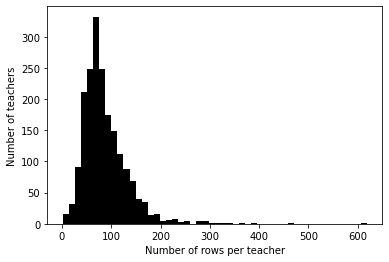

In [147]:
teacher_ids = list(np.unique(list(teacher_data['Teacher User ID'])))
n_teachers = len(teacher_ids)
print('{0} teacher IDs found'.format(n_teachers))

row_nos_per_teacher = {}
n_rows_per_teacher = np.empty(n_teachers, dtype = int)

i = 0
for teacher_id in tqdm(teacher_ids):
    row_nos_per_teacher[teacher_id] = np.where(list(teacher_data['Teacher User ID']) == teacher_id)[0]
    n_rows_per_teacher[i] = len(row_nos_per_teacher[teacher_id])
    i += 1

#n_rows_per_teacher = [len(v) for v in list(row_nos_per_teacher.values())]
plt.figure()
plt.hist(n_rows_per_teacher, 50, color = 'k')
plt.xlabel('Number of rows per teacher')
plt.ylabel('Number of teachers')

In [11]:
teacher_student_ids = list(teacher_data['identifier'])
student_ids_per_teacher = {}

for teacher_id in teacher_ids:
    student_ids_per_teacher[teacher_id] = [teacher_student_ids[row] for row in row_nos_per_teacher[teacher_id]]

# Verify that each student ID occurs only once per teacher
n_student_ids_per_teacher = [len(np.unique(s)) for s in list(student_ids_per_teacher.values())]
assert(n_student_ids_per_teacher == n_rows_per_teacher).all()

## Fetch supervisor entries for each teacher

In [12]:
sup_student_ids = list(sup_data['UID'])
n_sup_student_ids = len(sup_student_ids)
assert(len(np.unique(sup_student_ids)) == n_sup_student_ids)

#sup_row_nos_per_teacher = {teacher_id: [] for teacher_id in teacher_ids}
sup_row_nos_per_teacher = {}
n_rows_checked_per_teacher = np.zeros(n_teachers)

for teacher_id in tqdm(teacher_ids): # Iterate over all teachers
    
    #for i in range(n_sup_student_ids): # Iterate over all students checked by supervisors
     #   if sup_student_ids[i] in student_ids_per_teacher[teacher_id]: # This is a student of that teacher_id checked by a supervisor 
      #      sup_row_nos_per_teacher[teacher_id].append(sup_student_ids[i])
            
    # Iterate over all students checked by supervisors, and store student ids for each teacher
    sup_row_nos_per_teacher[teacher_id] = [i for i in range(n_sup_student_ids) if sup_student_ids[i] in student_ids_per_teacher[teacher_id]]
    n_rows_checked_per_teacher[list(teacher_ids).index(teacher_id)] = len(sup_row_nos_per_teacher[teacher_id])
        
assert(len(n_rows_checked_per_teacher) == n_teachers)

100%|███████████████████████████████████████| 1920/1920 [00:44<00:00, 42.71it/s]


Text(0, 0.5, 'Number of teachers')

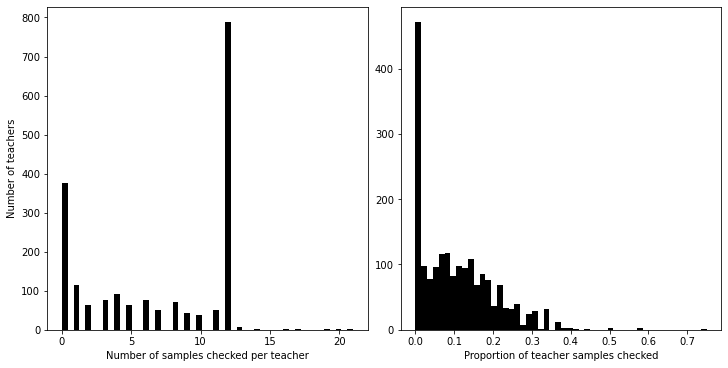

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, constrained_layout = True, figsize = (10, 5))

ax[0].hist(np.array(n_rows_checked_per_teacher), 50, color = 'k')
ax[0].set_xlabel('Number of samples checked per teacher')

ax[1].hist(np.divide(np.array(n_rows_checked_per_teacher), np.array(n_rows_per_teacher)), 50, color = 'k')
ax[1].set_xlabel('Proportion of teacher samples checked')
ax[0].set_ylabel('Number of teachers')

In [14]:
for n_samples in range(1, 21):
    
    print('{0} teachers have at least {1} samples checked'.format(np.sum(n_rows_checked_per_teacher >= n_samples), n_samples))

1544 teachers have at least 1 samples checked
1430 teachers have at least 2 samples checked
1366 teachers have at least 3 samples checked
1290 teachers have at least 4 samples checked
1198 teachers have at least 5 samples checked
1134 teachers have at least 6 samples checked
1057 teachers have at least 7 samples checked
1007 teachers have at least 8 samples checked
936 teachers have at least 9 samples checked
892 teachers have at least 10 samples checked
855 teachers have at least 11 samples checked
805 teachers have at least 12 samples checked
17 teachers have at least 13 samples checked
10 teachers have at least 14 samples checked
9 teachers have at least 15 samples checked
9 teachers have at least 16 samples checked
6 teachers have at least 17 samples checked
4 teachers have at least 18 samples checked
4 teachers have at least 19 samples checked
3 teachers have at least 20 samples checked


## Get Levels and Scores

In [16]:
teacher_constants = ['Subject', 'class']
sup_constants = ['subject', 'class']

teacher_level_variables = ['1st question Level',  '2nd question Level', '3rd question Level', 'baseline']
sup_level_variables = ['1st question Level', '2nd question Level', '3rd question Level', 'baseline']
n_levels = len(teacher_level_variables)
level_values = ['Arumbu', 'Mottu', 'Malar']

teacher_score_variables = ['1st level score', '2nd level score', '3rd level score']
sup_score_variables = ['1st level score', '2nd level score', '3rd level score']
n_scores = len(teacher_score_variables)

print('Checking level data entries for teachers')
for row in tqdm(range(teacher_n_rows)):
    assert(teacher_data['1st question Level'][row] in level_values)
    assert(teacher_data['1st question Level'][row] == teacher_data['baseline'][row]) # 1st level should always correspond to the baseline level.
    for v in ['2nd question Level', '3rd question Level']:
        assert(teacher_data[v][row] in level_values or np.isnan(teacher_data[v][row]))

print('Checking level data entries for supervisors')
for row in tqdm(range(sup_n_rows)):
    assert(sup_data['1st question Level'][row] in level_values)
    assert(sup_data['1st question Level'][row] == sup_data['baseline'][row]) # 1st level should always correspond to the baseline level.
    for v in ['2nd question Level', '3rd question Level']:
        assert(sup_data[v][row] in level_values or np.isnan(sup_data[v][row]))

Checking level data entries for teachers


100%|█████████████████████████████████| 166850/166850 [01:07<00:00, 2468.23it/s]


Checking level data entries for supervisors


100%|███████████████████████████████████| 13577/13577 [00:04<00:00, 3204.65it/s]


## Calculate discrepancy

### Level discrepancy

In [75]:
""" 
Condition for mismatch: 
       '1st question level' for that student is NOT matching between the 2 sets 
    OR 1st matches but 2nd doesn't (if it's available in at least one) 
    OR 1st and 2nd matches but 3rd doesn't (if it's available in at least one)

"""

#score_discrepancy = {}
level_discrepancy = {}
n_mismatch = {}

for teacher_id in tqdm(teacher_ids):
    
    row_nos = list(row_nos_per_teacher[teacher_id])
    student_ids = list(student_ids_per_teacher[teacher_id])
    
    sup_row_nos = list(sup_row_nos_per_teacher[teacher_id])
    
    if len(sup_row_nos) > 0: # For this teacher, at least one student has been checked by supervisor
        
        level_disc = np.zeros(len(sup_row_nos), dtype = int)
        n_mismatch[teacher_id] = 0
        #score_disc = np.zeros(len(sup_row_nos), dtype = bool)
        
        for sup_row in sup_row_nos: # Iterate over students checked by supervisor for this teacher
            
            student_id = sup_student_ids[sup_row]
            teacher_row_no = row_nos[student_ids.index(student_id)]
            
            # Check that subject and class match between the teacher and supervisor
            for c in range(len(teacher_constants)):
                assert(teacher_data[teacher_constants[c]][teacher_row_no] == sup_data[sup_constants[c]][sup_row])
                
            teacher_levels = [teacher_data[v][teacher_row_no] for v in teacher_level_variables]
            
            sup_levels = [sup_data[v][sup_row] for v in sup_level_variables]
            
            if np.logical_not(teacher_levels[0] == sup_levels[0]): 
                # Condition 1: '1st question level' does not match
                level_disc[sup_row_nos.index(sup_row)] = 1
                n_mismatch[teacher_id] += 1
                continue
            else:                             
                # '1st question level' matches
                if np.logical_or(np.logical_not(isinstance(teacher_levels[1], str)), np.logical_not(isinstance(sup_levels[1], str))):
                    # '2nd question level' does not exist for either teacher or supervisor
                    continue
                else:
                    # '2nd question level' exists for both teacher and supervisor
                    if np.logical_not(teacher_levels[1] == sup_levels[1]):
                        # Condition 2: '2nd question level' does not match
                        level_disc[sup_row_nos.index(sup_row)] = 1
                        n_mismatch[teacher_id] += 1
                        continue
                    else:
                        # '2nd question level' matches
                        if np.logical_or(np.logical_not(isinstance(teacher_levels[2], str)), np.logical_not(isinstance(sup_levels[2], str))):
                            # '3rd question level' does not exist for either teacher or supervisor
                            continue
                        else:
                            # '3rd question level' exists for both teacher and supervisor
                            if np.logical_not(teacher_levels[2] == sup_levels[2]):
                                # Condition 3: '3rd question level' does not match
                                level_disc[sup_row_nos.index(sup_row)] = 1
                                n_mismatch[teacher_id] += 1
                
                   
        level_discrepancy[teacher_id] = np.sum(level_disc)/len(sup_row_nos) # Proportion of students checked by supervisor that have a non-matching level


100%|█████████████████████████████████████| 1920/1920 [00:01<00:00, 1109.86it/s]


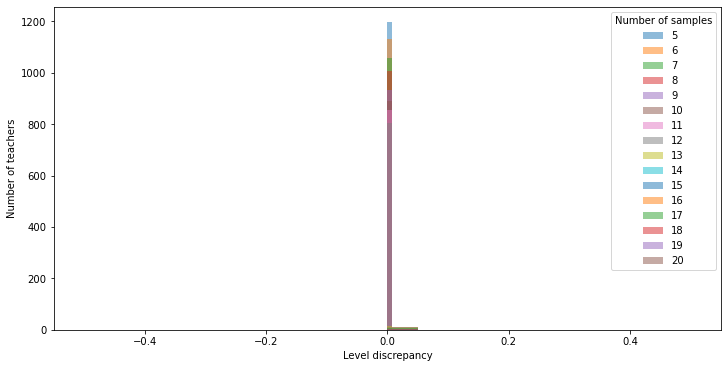

In [76]:
plt.figure(constrained_layout = True, figsize = (10, 5))
for n_samples in range(5, 21):
    
    # List of teachers with at least n_samples samples checked by supervisor
    teacher_ids_selected = [teacher_ids[i] for i in range(n_teachers) if n_rows_checked_per_teacher[i] >= n_samples]
    
    # Level discrepancy scores for the set of teachers selected above
    level_disc = [level_discrepancy[teacher_id] for teacher_id in teacher_ids_selected]
    
    # Plot distribution of level discrepancy scores
    plt.hist(level_disc, 20, alpha = 0.5, label = n_samples)

plt.xlabel('Level discrepancy')
plt.ylabel('Number of teachers')
plt.legend(title = 'Number of samples')

There is exactly 1 mismatch for every teacher: that's very strange.

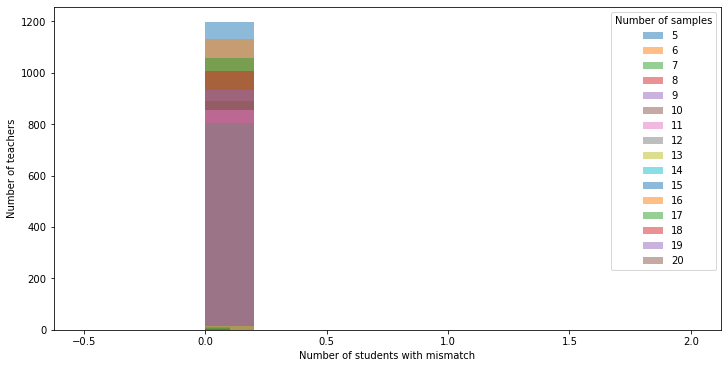

In [77]:
plt.figure(constrained_layout = True, figsize = (10, 5))
for n_samples in range(5, 21):
    
    # List of teachers with at least n_samples samples checked by supervisor
    teacher_ids_selected = [teacher_ids[i] for i in range(n_teachers) if n_rows_checked_per_teacher[i] >= n_samples]
    
    # Number of mismatches for the set of teachers selected above
    n = [n_mismatch[teacher_id] for teacher_id in teacher_ids_selected]
    
    # Plot distribution of number of mismatches
    plt.hist(n, alpha = 0.5, label = n_samples)

plt.xlabel('Number of students with mismatch')
plt.ylabel('Number of teachers')
plt.legend(title = 'Number of samples')

In [79]:
n = list(n_mismatch.values())
np.linalg.norm(n - np.zeros(len(n)))

2.0

In [80]:
np.sum(n)

2

In [96]:
n_samples = 1

# List of teachers with at least n_samples samples checked by supervisor
teacher_ids_selected = [teacher_ids[i] for i in range(n_teachers) if n_rows_checked_per_teacher[i] >= n_samples]

# Select a teacher at random from those with at least n_samples samples checked
teacher_id = teacher_ids_selected[np.random.randint(0, len(teacher_ids_selected))]
#teacher_id = teacher_ids_selected[np.where(n)[0][0]] # Select a teacher with 1 or more mismatches
print('{0} mismatches'.format(n_mismatch[teacher_id]))

# Get set of students for that teacher checked by supervisor
sup_row_nos = list(sup_row_nos_per_teacher[teacher_id])
student_ids = [sup_student_ids[sup_row] for sup_row in sup_row_nos]
row_nos = list(row_nos_per_teacher[teacher_id])
teacher_row_nos = [row_nos[student_ids_per_teacher[teacher_id].index(student_id)] for student_id in student_ids]
assert(len(sup_row_nos) == len(teacher_row_nos))

# Print teacher and supervisor data for each student 

print('Level // Teacher // Supervisor')
n_students = len(sup_row_nos)

for i in range(n_students):
    
    print('    Student {0}'.format(i + 1))
    t_row = teacher_row_nos[i]
    s_row = sup_row_nos[i]
    assert(teacher_data['identifier'][t_row] == sup_data['UID'][s_row]) # Make sure that student ID is the same for teacher and supervisor
    
    for v in range(n_levels - 1):
        t_var = teacher_level_variables[v]
        s_var = sup_level_variables[v]
        if t_var == s_var:
            match = ''
        else:
            match = ' // Mismatch'
        
        print('    {0} // {1} // {2}{3}'.format(v + 1, teacher_data[t_var][t_row], sup_data[s_var][s_row], match))

0 mismatches
Level // Teacher // Supervisor
    Student 1
    1 // Arumbu // Arumbu
    2 // Mottu // Mottu
    3 // nan // nan
    Student 2
    1 // Mottu // Mottu
    2 // nan // nan
    3 // nan // nan
    Student 3
    1 // Arumbu // Arumbu
    2 // Mottu // nan
    3 // nan // nan
    Student 4
    1 // Arumbu // Arumbu
    2 // Mottu // nan
    3 // nan // nan
    Student 5
    1 // Arumbu // Arumbu
    2 // Mottu // Mottu
    3 // nan // nan
    Student 6
    1 // Mottu // Mottu
    2 // nan // nan
    3 // nan // nan
    Student 7
    1 // Arumbu // Arumbu
    2 // Mottu // nan
    3 // nan // nan
    Student 8
    1 // Mottu // Mottu
    2 // nan // nan
    3 // nan // nan
    Student 9
    1 // Arumbu // Arumbu
    2 // Mottu // Mottu
    3 // nan // nan
    Student 10
    1 // Mottu // Mottu
    2 // nan // nan
    3 // nan // nan
    Student 11
    1 // Arumbu // Arumbu
    2 // nan // nan
    3 // nan // nan
    Student 12
    1 // Arumbu // Arumbu
    2 // nan // nan
   

### Score discrepancy

In [19]:
score_discrepancy = {}
n_mismatch = {}

for teacher_id in tqdm(teacher_ids):
    
    row_nos = list(row_nos_per_teacher[teacher_id])
    student_ids = list(student_ids_per_teacher[teacher_id])
    
    sup_row_nos = list(sup_row_nos_per_teacher[teacher_id])
    
    if len(sup_row_nos) > 0: # For this teacher, at least one student has been checked by supervisor
        
        score_disc = np.empty([len(sup_row_nos), n_scores])
        n_mismatch[teacher_id] = 0
        #score_disc = np.zeros(len(sup_row_nos), dtype = bool)
        
        for sup_row in sup_row_nos: # Iterate over students checked by supervisor for this teacher
            
            student_id = sup_student_ids[sup_row]
            teacher_row_no = row_nos[student_ids.index(student_id)]
            
            # Check that subject and class match between the teacher and supervisor
            for c in range(len(teacher_constants)):
                assert(teacher_data[teacher_constants[c]][teacher_row_no] == sup_data[sup_constants[c]][sup_row])
                
            teacher_levels = [teacher_data[v][teacher_row_no] for v in teacher_level_variables]
            teacher_scores = [teacher_data[v][teacher_row_no] for v in teacher_score_variables]
            
            sup_levels = [sup_data[v][sup_row] for v in sup_level_variables]
            sup_scores = [sup_data[v][sup_row] for v in sup_score_variables]
            
            score_disc[sup_row_nos.index(sup_row), 0] = sup_scores[0] - teacher_scores[0]
            if np.abs(sup_scores[0] - teacher_scores[0]) > 0:
                n_mismatch[teacher_id] += 1
            
            if np.logical_or(np.logical_not(isinstance(teacher_levels[1], str)), np.logical_not(isinstance(sup_levels[1], str))):
                # '2nd question level' does not exist for either teacher or supervisor
                
                score_disc[sup_row_nos.index(sup_row), 1] = np.nan
                continue
            else:
                # '2nd question level' exists for both teacher and supervisor
                
                score_disc[sup_row_nos.index(sup_row), 1] = sup_scores[1] - teacher_scores[1]
                if np.abs(sup_scores[1] - teacher_scores[1]) > 0:
                    n_mismatch[teacher_id] += 1
                
                if np.logical_or(np.logical_not(isinstance(teacher_levels[2], str)), np.logical_not(isinstance(sup_levels[2], str))):
                    # '3rd question level' does not exist for either teacher or supervisor
                    
                    score_disc[sup_row_nos.index(sup_row), 2] = np.nan
                    continue
                else:
                    # '3rd question level' exists for both teacher and supervisor
                    
                    score_disc[sup_row_nos.index(sup_row), 2] = sup_scores[2] - teacher_scores[2]
                    if np.abs(sup_scores[2] - teacher_scores[2]) > 0:
                        n_mismatch[teacher_id] += 1
                
                   
        score_discrepancy[teacher_id] = np.nanmean(score_disc, axis = 0) # Proportion of students checked by supervisor that have a non-matching level
        assert(len(score_discrepancy[teacher_id]) == n_scores)

  0%|                                                  | 0/1920 [00:00<?, ?it/s]/var/folders/fv/dt8qr2_164gdg58grl7lhznc0000gn/T/ipykernel_44353/3219601373.py:61: RuntimeWarning: Mean of empty slice
  score_discrepancy[teacher_id] = np.nanmean(score_disc, axis = 0) # Proportion of students checked by supervisor that have a non-matching level
/var/folders/fv/dt8qr2_164gdg58grl7lhznc0000gn/T/ipykernel_44353/3219601373.py:61: RuntimeWarning: Mean of empty slice
  score_discrepancy[teacher_id] = np.nanmean(score_disc, axis = 0) # Proportion of students checked by supervisor that have a non-matching level
/var/folders/fv/dt8qr2_164gdg58grl7lhznc0000gn/T/ipykernel_44353/3219601373.py:61: RuntimeWarning: Mean of empty slice
  score_discrepancy[teacher_id] = np.nanmean(score_disc, axis = 0) # Proportion of students checked by supervisor that have a non-matching level
  5%|██                                     | 104/1920 [00:00<00:06, 287.37it/s]/var/folders/fv/dt8qr2_164gdg58grl7lhznc0000gn/T

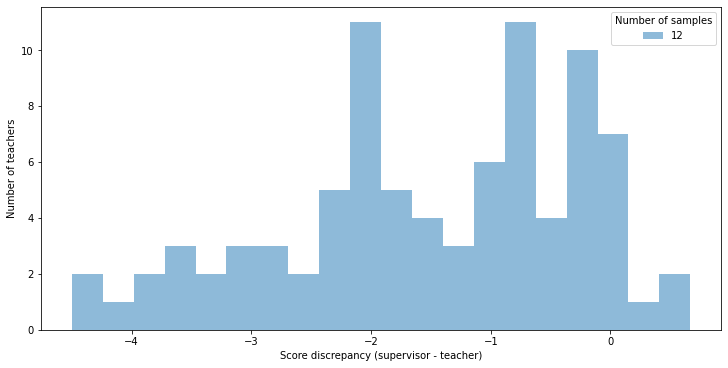

In [137]:
plt.figure(constrained_layout = True, figsize = (10, 5))
for n_samples in range(12, 13):
    
    # List of teachers with at least n_samples samples checked by supervisor
    teacher_ids_selected = [teacher_ids[i] for i in range(n_teachers) if n_rows_checked_per_teacher[i] >= n_samples]
    
    score_disc = [score_discrepancy[teacher_id][0] for teacher_id in teacher_ids_selected]
    #score_disc = [np.nanmean(score_discrepancy[teacher_id]) for teacher_id in teacher_ids_selected]
    plt.hist(score_disc, 20, alpha = 0.5, label = n_samples)

plt.xlabel('Score discrepancy (supervisor - teacher)')
plt.ylabel('Number of teachers')
plt.legend(title = 'Number of samples')

# Sub-sample data with different sampling strategies

## Scores for first question for different learning levels

For each subject and each class, students answer questions at 'Arumbu', 'Mottu' and/or 'Malar' (learning levels). 
For simplicity, let us look only at the first level, since that exists for all students.

In [172]:
# Get number of subjects
subjects_all = teacher_data['Subject']
subjects = np.unique(subjects_all)
n_subjects = len(subjects)
print('{0} subjects found: {1}'.format(n_subjects, subjects))

# Get classes
class_all = teacher_data['class']
classes = np.unique(class_all)

# For each subject, collect score for each level
scores_by_subject = {subject: {cl: {level: [] for level in level_values} for cl in classes} for subject in subjects}

for row in tqdm(range(teacher_n_rows)):
    
    cl = teacher_data['class'][row]
    sub = teacher_data['Subject'][row]
    level = teacher_data['1st question Level'][row]
    score = teacher_data['1st level score'][row]
    
    scores_by_subject[sub][cl][level].append(score)
    

assert(np.sum([np.sum([np.sum([len(scores_by_subject[subject][cl][level]) for level in level_values]) for cl in classes]) for subject in subjects]) == teacher_n_rows)

3 subjects found: ['English' 'Mathematics' 'Tamil']


100%|███████████████████████████████████| 166850/166850 [02:35<00:00, 1070.64it/s]


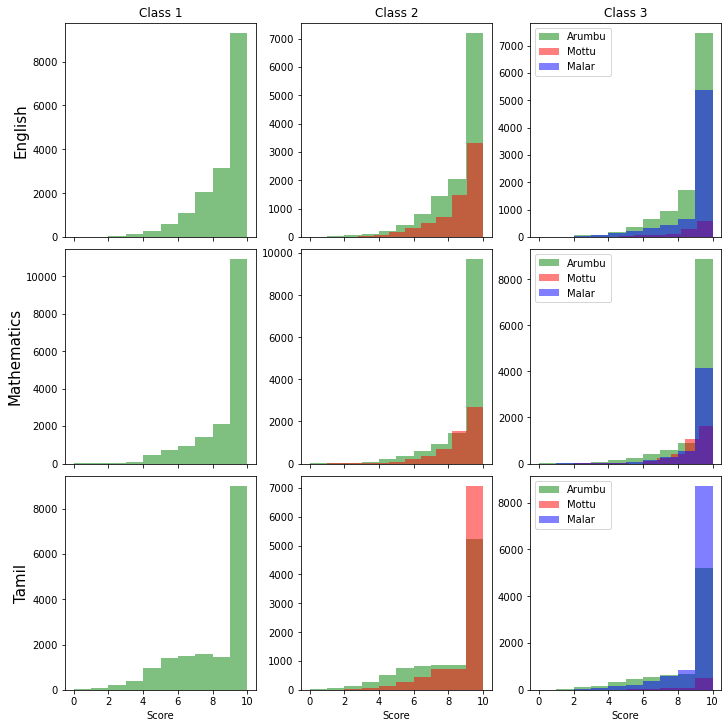

In [22]:
# Plot distribution of scores for each subject, for each level
colors = {'Arumbu': 'g', 'Mottu': 'r', 'Malar': 'b'}
fig, ax = plt.subplots(nrows = n_subjects, ncols = len(level_values), constrained_layout = True, figsize = (10, 10), sharex = True)
row = 0
for sub in subjects:
    col = 0
    ax[row, 0].set_ylabel(sub, fontsize = 15)
    for cl in classes:
        for level in level_values:
            ax[row, col].hist(scores_by_subject[sub][cl][level], color = colors[level], label = level, alpha = 0.5)
        col += 1
    ax[row, -1].legend()
    row += 1
    
for col in range(len(level_values)):
    ax[-1, col].set_xlabel('Score')
    ax[0, col].set_title('Class {0}'.format(classes[col]))

## Classification boundaries provided as meta-data:

In [173]:
cb = {'Tamil': 8, 'English': 8, 'Mathematics': 9} # classification boundaries (pass/fail)

Note: students *at* the classification boundary are passed.

## Rank samples by closeness to classification boundary

Note: 'closeness' here is not the absolute difference, but the *signed* difference, between the score and the classification boundary.
This is because teachers are likely to increase scores, not decrease scores, so the direction of the difference between the score and the classification boundary matters.

In [174]:
cb_diff_by_sub_class = {sub: {cl: [] for cl in classes} for sub in subjects}
sample_ids_by_sub_class = {sub: {cl: [] for cl in classes} for sub in subjects}
sample_ids_ordered_by_sub_class = {sub: {} for sub in subjects}
cb_diff_all = []
cb_diff_checked = []

for row in tqdm(range(teacher_n_rows)):
    
    cl = teacher_data['class'][row]
    sub = teacher_data['Subject'][row]
    score = teacher_data['1st level score'][row]
    
    sample_ids_by_sub_class[sub][cl].append(row)
    cb_diff_by_sub_class[sub][cl].append(score - cb[sub])
    cb_diff_all.append(score - cb[sub])
    
    student_id = teacher_data['identifier'][row]
    
    if student_id in sup_student_ids:
        cb_diff_checked.append(score - cb[sub])
    
for sub in subjects:
    for cl in classes:
        order = np.argsort(cb_diff_by_sub_class[sub][cl]).astype(int)
        sample_ids_ordered_by_sub_class[sub][cl] = [sample_ids_by_sub_class[sub][cl][index] for index in order]

100%|████████████████████████████████████| 166850/166850 [08:21<00:00, 332.40it/s]


Text(0.5, 1.0, 'P value = 0.0')

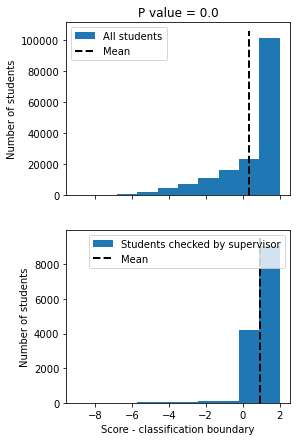

In [175]:
fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (4, 7))
results = ax[0].hist(cb_diff_all, 10, label = 'All students', density = False)
cb_diff_mean = np.mean(cb_diff_all)
ylim = ax[0].get_ylim()
ax[0].plot([cb_diff_mean, cb_diff_mean], ylim, color = 'k', linewidth = 2, linestyle = '--', label = 'Mean')

ax[1].hist(cb_diff_checked, results[1], alpha = 1, label = 'Students checked by supervisor', density = False)
cb_diff_mean = np.mean(cb_diff_checked)
ylim = ax[1].get_ylim()
ax[1].plot([cb_diff_mean, cb_diff_mean], ylim, color = 'k', linewidth = 2, linestyle = '--', label = 'Mean')

ax[1].set_xlabel('Score - classification boundary')
ax[0].set_ylabel('Number of students')
ax[1].set_ylabel('Number of students')
ax[0].legend()
ax[1].legend()

pval = mannwhitneyu(np.random.choice(cb_diff_all, len(cb_diff_checked), replace = False), cb_diff_checked, alternative = 'less')[1]
ax[0].set_title('P value = {0}'.format(np.round(pval, 10)))

## Check whether selected samples are closest to classification boundary

In [148]:
n_samples = 12
teacher_ids_selected = [teacher_ids[i] for i in range(n_teachers) if n_rows_checked_per_teacher[i] == n_samples]
print(len(teacher_ids_selected))

788


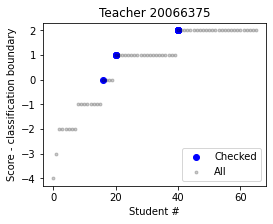

In [165]:
teacher_id = np.random.choice(teacher_ids_selected)

row_nos = list(row_nos_per_teacher[teacher_id])
student_ids = list(student_ids_per_teacher[teacher_id])
sup_row_nos = list(sup_row_nos_per_teacher[teacher_id])

scores = []

for row in row_nos:
    
    sub = teacher_data['Subject'][row]
    scores.append(teacher_data['1st level score'][row] - cb[sub])

checked_scores = []

for sup_row in sup_row_nos: # Iterate over students checked by supervisor for this teacher
            
    student_id = sup_student_ids[sup_row]
    teacher_row_no = row_nos[student_ids.index(student_id)]
    sub = teacher_data['Subject'][teacher_row_no]

    checked_scores.append(teacher_data['1st level score'][teacher_row_no] - cb[sub]) 

plt.figure(figsize = (4, 3))
plt.title('Teacher {0}'.format(teacher_id))
scores_ordered = np.sort(scores)
x_all = list(range(len(row_nos)))
x_checked = [bisect.bisect_left(scores_ordered, score) for score in checked_scores]

plt.scatter(x_checked, checked_scores, color = 'b', marker = 'o', label = 'Checked')
plt.scatter(x_all, scores_ordered, color = 'k', marker = '.', alpha = 0.2, label = 'All')

plt.ylabel('Score - classification boundary')
plt.xlabel('Student #')
plt.legend()

## Create random and ranked sub-samples of dataset 

In [176]:
# Select how many samples to use for testing sampling strategy
sub_sample_size = 5

# Select teachers (sub-sample size should be no more than half of the total samples for selected teachers)
min_n_samples = 2*sub_sample_size 
teacher_ids_selected = [teacher_ids[i] for i in range(n_teachers) if n_rows_checked_per_teacher[i] >= min_n_samples]

# Create dictionaries to store row numbers and student ids in sub-samples
ranked_sub_samples = {}
random_sub_samples = {}

ranked_sub_sample_student_ids = {}
random_sub_sample_student_ids = {}

cb_diff_checked_all = []

# Iterate over selected teachers
print('Creating sub-samples for {0} teachers'.format(len(teacher_ids_selected)))
for teacher_id in tqdm(teacher_ids_selected):
    
    # All row numbers and students for that teacher
    row_nos = list(row_nos_per_teacher[teacher_id])
    student_ids = list(student_ids_per_teacher[teacher_id])
    assert(len(student_ids) == len(row_nos))
    
    # Teacher row numbers checked by supervisor
    row_nos_checked = [row for row in row_nos if student_ids[row_nos.index(row)] in sup_student_ids]
    assert(len(row_nos_checked) >= min_n_samples)
    
    # Difference between score and classification boundary for samples checked by supervisor
    cb_diff = np.array([cb_diff_all[row] for row in row_nos_checked])
    cb_diff_checked_all.append(cb_diff)
    
    # In our ranking, we first want to check scores that are equal to or slightly higher than the classification boundary.
    # Then we will check scores that are slightly lower than the classification boundary.
    # So we need to separately rank-order the scores with non-negative and negative difference from classification boundary.
    
    
    pos_ind = np.where(cb_diff >= 0)[0].astype(int)       # Indices where score is equal to or greater than classification boundary 
    order_pos = np.argsort(cb_diff[pos_ind]).astype(int)  # Order of scores equal to or greater than classification boundary
    order_pos = [pos_ind[i] for i in order_pos]           # Indices where score is equal to or greater than classification boundary, ordered 
    
    neg_ind = np.where(cb_diff < 0)[0].astype(int)                 # Indices where score is less than classification boundary
    order_neg = np.flip(np.argsort(cb_diff[neg_ind])).astype(int)  # Order of scores less than classification boundary (descending)
    order_neg = [neg_ind[i] for i in order_neg]                    # Indices where score is less than classification boundary, ordered
    
    order = np.concatenate([order_pos, order_neg]).astype(int)  # Overall order: first scores equal to or greater than cb in ascending order, then scores less than cb in descending order
    assert(len(order) == len(row_nos_checked))
    
    row_nos_ordered = [row_nos_checked[index] for index in order]  # Teacher row numbers checked by supervisor, in order
    student_ids_ordered = [student_ids[row_nos.index(row)] for row in row_nos_ordered] # Student ids checked by supervisor for that teacher, in order
    
    ranked_sub_samples[teacher_id] = row_nos_ordered[:sub_sample_size] # Teacher row numbers selected for ranked sub-sample
    ranked_sub_sample_student_ids[teacher_id] = student_ids_ordered[:sub_sample_size] # Student IDs selected for ranked sub-sample
    
    # For random sample, select a subset of row numbers checked by supervisor
    random_sub_samples[teacher_id] = np.random.choice(row_nos_checked, size = sub_sample_size, replace = False)
    random_sub_sample_student_ids[teacher_id] = [student_ids[row_nos.index(row)] for row in random_sub_samples[teacher_id]]
    
cb_diff_checked_all = np.concatenate([cb_diff_checked_all[i] for i in range(len(teacher_ids_selected))])

Creating sub-samples for 892 teachers


100%|███████████████████████████████████████████| 892/892 [01:50<00:00,  8.08it/s]


## Check that ranked subset scores are closest to classification boundary

Text(0, 0.5, 'Number of samples (log scale)')

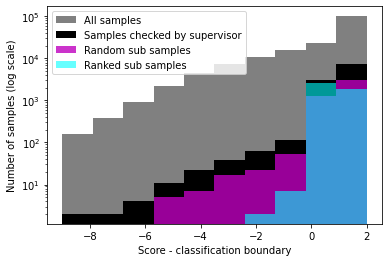

In [178]:
all_ranked_sub_sample_rows = np.concatenate([ranked_sub_samples[teacher_id] for teacher_id in teacher_ids_selected]).astype(int)
all_random_sub_sample_rows = np.concatenate([random_sub_samples[teacher_id] for teacher_id in teacher_ids_selected]).astype(int)

cb_diff_ranked_all = [cb_diff_all[row] for row in all_ranked_sub_sample_rows]
cb_diff_random_all = [cb_diff_all[row] for row in all_random_sub_sample_rows]
assert(len(cb_diff_ranked_all) == len(cb_diff_random_all))

plt.figure()
results = plt.hist(cb_diff_all, 10, color = 'gray', label = 'All samples')
bins = results[1]
plt.hist(cb_diff_checked_all, bins, color = 'k', label = 'Samples checked by supervisor')
plt.hist(cb_diff_random_all, bins, alpha = 0.8, color = 'm', label = 'Random sub samples')
plt.hist(cb_diff_ranked_all, bins, alpha = 0.6, color = 'cyan', label = 'Ranked sub samples')

plt.legend()
plt.yscale('log')
plt.xlabel('Score - classification boundary')
plt.ylabel('Number of samples (log scale)')

# Test sampling strategies: accuracy of discrepancy score

## Plot discrepancy scores for random and ranked sub-samples

In [122]:
real_disc_score = []
ranked_disc_score = []
random_disc_score = []

for teacher_id in tqdm(teacher_ids_selected):
    
    # Real discrepancy: previously calculated
    #real_disc_score.append(np.nanmean(score_discrepancy[teacher_id])) # Average score discrepancy for Level 1, 2 and 3 for that teacher - all checked samples
    real_disc_score.append(score_discrepancy[teacher_id][0]) # Only using Level 1 score discrepancy
    
    # Calculate discrepancy for ranked sub-sample
    
    row_nos = list(ranked_sub_samples[teacher_id])
    student_ids = ranked_sub_sample_student_ids[teacher_id]
    
    score_disc = np.empty([len(row_nos), n_scores])
    
    for row in row_nos: # Iterate over students in ranked sub-sample

        student_id = student_ids[row_nos.index(row)]
        sup_row = sup_student_ids.index(student_id)

        # Check that subject and class match between the teacher and supervisor
        for c in range(len(teacher_constants)):
            assert(teacher_data[teacher_constants[c]][row] == sup_data[sup_constants[c]][sup_row])

        teacher_levels = [teacher_data[v][row] for v in teacher_level_variables]
        teacher_scores = [teacher_data[v][row] for v in teacher_score_variables]

        sup_levels = [sup_data[v][sup_row] for v in sup_level_variables]
        sup_scores = [sup_data[v][sup_row] for v in sup_score_variables]

        score_disc[row_nos.index(row), 0] = sup_scores[0] - teacher_scores[0]

        if np.logical_or(np.logical_not(isinstance(teacher_levels[1], str)), np.logical_not(isinstance(sup_levels[1], str))):
            # '2nd question level' does not exist for either teacher or supervisor
            score_disc[row_nos.index(row), 1] = np.nan
            continue
        else:
            # '2nd question level' exists for both teacher and supervisor
            score_disc[row_nos.index(row), 1] = sup_scores[1] - teacher_scores[1]
            if np.logical_or(np.logical_not(isinstance(teacher_levels[2], str)), np.logical_not(isinstance(sup_levels[2], str))):
                # '3rd question level' does not exist for either teacher or supervisor
                score_disc[row_nos.index(row), 2] = np.nan
                continue
            else:
                # '3rd question level' exists for both teacher and supervisor
                score_disc[row_nos.index(row), 2] = sup_scores[2] - teacher_scores[2]

    #ranked_disc_score.append(np.nanmean(score_disc)) # Proportion of students in ranked sub-sample that have a non-matching level
    ranked_disc_score.append(np.nanmean(score_disc, axis = 0)[0]) # Only using 1st level score discrepancy
    
    # Calculate discrepancy for random sub-sample
    
    row_nos = list(random_sub_samples[teacher_id])
    student_ids = random_sub_sample_student_ids[teacher_id]
    
    score_disc = np.empty([len(row_nos), n_scores])
    
    for row in row_nos: # Iterate over students in ranked sub-sample

        student_id = student_ids[row_nos.index(row)]
        sup_row = sup_student_ids.index(student_id)

        # Check that subject and class match between the teacher and supervisor
        for c in range(len(teacher_constants)):
            assert(teacher_data[teacher_constants[c]][row] == sup_data[sup_constants[c]][sup_row])

        teacher_levels = [teacher_data[v][row] for v in teacher_level_variables]
        teacher_scores = [teacher_data[v][row] for v in teacher_score_variables]

        sup_levels = [sup_data[v][sup_row] for v in sup_level_variables]
        sup_scores = [sup_data[v][sup_row] for v in sup_score_variables]

        score_disc[row_nos.index(row), 0] = sup_scores[0] - teacher_scores[0]

        if np.logical_or(np.logical_not(isinstance(teacher_levels[1], str)), np.logical_not(isinstance(sup_levels[1], str))):
            # '2nd question level' does not exist for either teacher or supervisor
            score_disc[row_nos.index(row), 1] = np.nan
            continue
        else:
            # '2nd question level' exists for both teacher and supervisor
            score_disc[row_nos.index(row), 1] = sup_scores[1] - teacher_scores[1]
            if np.logical_or(np.logical_not(isinstance(teacher_levels[2], str)), np.logical_not(isinstance(sup_levels[2], str))):
                # '3rd question level' does not exist for either teacher or supervisor
                score_disc[row_nos.index(row), 2] = np.nan
                continue
            else:
                # '3rd question level' exists for both teacher and supervisor
                score_disc[row_nos.index(row), 2] = sup_scores[2] - teacher_scores[2]

    #random_disc_score.append(np.nanmean(score_disc)) # Proportion of students in ranked sub-sample that have a non-matching level
    random_disc_score.append(np.nanmean(score_disc, axis = 0)[0]) # Only using 1st level discrepancy

  0%|                                                   | 0/416 [00:00<?, ?it/s]/var/folders/fv/dt8qr2_164gdg58grl7lhznc0000gn/T/ipykernel_44353/2355767358.py:51: RuntimeWarning: Mean of empty slice
  ranked_disc_score.append(np.nanmean(score_disc, axis = 0)[0]) # Only using 1st level score discrepancy
/var/folders/fv/dt8qr2_164gdg58grl7lhznc0000gn/T/ipykernel_44353/2355767358.py:93: RuntimeWarning: Mean of empty slice
  random_disc_score.append(np.nanmean(score_disc, axis = 0)[0]) # Only using 1st level discrepancy
/var/folders/fv/dt8qr2_164gdg58grl7lhznc0000gn/T/ipykernel_44353/2355767358.py:93: RuntimeWarning: Mean of empty slice
  random_disc_score.append(np.nanmean(score_disc, axis = 0)[0]) # Only using 1st level discrepancy
  3%|█▍                                       | 14/416 [00:00<00:03, 121.17it/s]/var/folders/fv/dt8qr2_164gdg58grl7lhznc0000gn/T/ipykernel_44353/2355767358.py:51: RuntimeWarning: Mean of empty slice
  ranked_disc_score.append(np.nanmean(score_disc, axis = 0)[0

We expect the discrepancy scores for random sub-sample to be close to the 'real' discrepancy scores.
We expect discrepancy scores for ranked sub-sample to be *higher* than the 'real' discrepancy scores, because our model is that teachers are incentivised to inflate scores near the classification boundaries.

Text(0.5, 0, 'Discrepancy score')

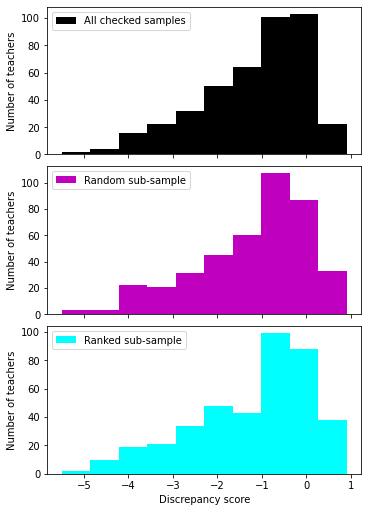

In [166]:
fig, ax = plt.subplots(nrows = 3, sharex = True, constrained_layout = True, figsize = (5, 7))

results = ax[0].hist(real_disc_score, color = 'k', label = 'All checked samples')
bins = results[1]
ax[1].hist(random_disc_score, bins, color = 'm', label = 'Random sub-sample', alpha = 1)
ax[2].hist(ranked_disc_score, bins, color = 'cyan', label = 'Ranked sub-sample', alpha = 1)
#plt.yscale('log')

for i in range(3):
    ax[i].legend()
    ax[i].set_ylabel('Number of teachers')
ax[2].set_xlabel('Discrepancy score')

## Compare distribution of discrepancy score accuracy for random and ranked sub-samples

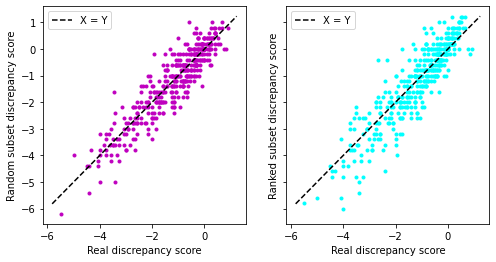

In [124]:
fig, ax = plt.subplots(ncols = 2, sharey = True, figsize = (8, 4))

ax[0].scatter(real_disc_score, random_disc_score, color = 'm', marker = '.')
ax[0].set_xlabel('Real discrepancy score')
ax[0].set_ylabel('Random subset discrepancy score')
xlim = ax[0].get_xlim()
ax[0].plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], color = 'k', linestyle = '--', linewidth = 1.5, label = 'X = Y')
ax[0].legend()

ax[1].scatter(real_disc_score, ranked_disc_score, color = 'cyan', marker = '.')
ax[1].set_xlabel('Real discrepancy score')
ax[1].set_ylabel('Ranked subset discrepancy score')
xlim = ax[1].get_xlim()
ax[1].plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], color = 'k', linestyle = '--', linewidth = 1.5, label = 'X = Y')
ax[1].legend()


(-0.5, 1.5)

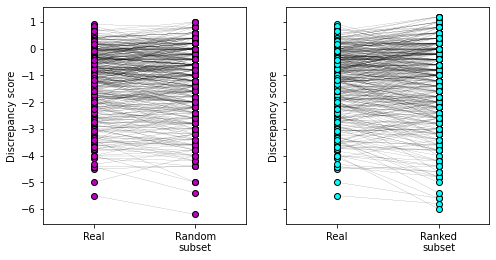

In [125]:
fig, ax = plt.subplots(ncols = 2, sharey = True, figsize = (8, 4))

n_teachers = len(real_disc_score)
y = np.concatenate([np.reshape(real_disc_score, [1, -1]), np.reshape(random_disc_score, [1, -1])], axis = 0)
assert(y.shape[0] == 2)
assert(y.shape[1] == n_teachers)
x = [0, 1]

ax[0].plot(x, y, color = 'k', linewidth = 0.1, marker = 'o', markerfacecolor = 'm')
ax[0].set_xticks(x)
ax[0].set_xticklabels(['Real', 'Random\nsubset'])
ax[0].set_ylabel('Discrepancy score')
ax[0].set_xlim([-0.5, 1.5])

y = np.concatenate([np.reshape(real_disc_score, [1, -1]), np.reshape(ranked_disc_score, [1, -1])], axis = 0)
assert(y.shape[0] == 2)
assert(y.shape[1] == n_teachers)
x = [0, 1]

ax[1].plot(x, y, color = 'k', marker = 'o', linewidth = 0.1, markerfacecolor = 'cyan')
ax[1].set_xticks(x)
ax[1].set_xticklabels(['Real', 'Ranked\nsubset'])
ax[1].set_ylabel('Discrepancy score')
ax[1].set_xlim([-0.5, 1.5])


Text(0.5, 1.0, 'P value = 0.81')

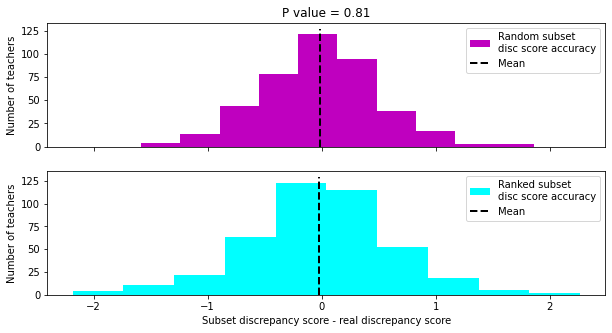

In [126]:
random_accuracy = np.array(random_disc_score) - np.array(real_disc_score)
ranked_accuracy = np.array(ranked_disc_score) - np.array(real_disc_score)

fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (10, 5))

ax[0].hist(random_accuracy, color = 'm', label = 'Random subset\ndisc score accuracy')
mean_accuracy = np.mean(random_accuracy)
ylim = ax[0].get_ylim()
ax[0].plot([mean_accuracy, mean_accuracy], ylim, color = 'k', linewidth = 2, linestyle = '--', label = 'Mean')
ax[0].set_ylabel('Number of teachers')
ax[0].legend()

ax[1].hist(ranked_accuracy, color = 'cyan', label = 'Ranked subset\ndisc score accuracy')
mean_accuracy = np.mean(ranked_accuracy)
ylim = ax[1].get_ylim()
ax[1].plot([mean_accuracy, mean_accuracy], ylim, color = 'k', linewidth = 2, linestyle = '--', label = 'Mean')
ax[1].set_ylabel('Number of teachers')
ax[1].set_xlabel('Subset discrepancy score - real discrepancy score')
ax[1].legend()

pval = mannwhitneyu(ranked_accuracy, random_accuracy, alternative = 'two-sided')[1]
ax[0].set_title('P value = {0}'.format(np.round(pval, 2)))

High p-value (> 0.05) indicates that these distributions are identical.

# Test sampling strategies: worst offenders

## Select 'worst offender' teachers

Text(0, 0.5, 'Number of teachers')

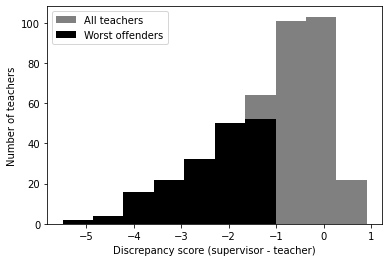

In [179]:
perc_wo = 20 # Percentile of teachers to be selected as worst offenders
n_teachers_selected = len(teacher_ids_selected)
n_wo = int(perc_wo*n_teachers_selected/100) # Number of teachers to be selected as worst offenders

order = np.argsort(real_disc_score).astype(int) # Ascending order of discrepancy score for selected teachers - lower is worse
teacher_ids_wo = [teacher_ids_selected[index] for index in order[:n_wo]] # Select perc_wo% of teachers with worst discrepancy scores
disc_score_wo = [real_disc_score[teacher_ids_selected.index(t_id)] for t_id in teacher_ids_wo]

plt.figure()
result = plt.hist(real_disc_score, color = 'gray', label = 'All teachers')
plt.hist(disc_score_wo, result[1], color = 'k', label = 'Worst offenders')
plt.legend()
plt.xlabel('Discrepancy score (supervisor - teacher)')
plt.ylabel('Number of teachers')

## Compare ability to detect worst offenders for different sampling strategies

Text(0, 0.5, 'Number of teachers')

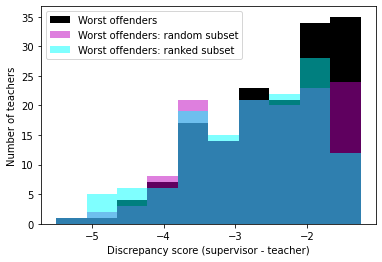

In [169]:
random_disc_score_wo = [random_disc_score[teacher_ids_selected.index(t_id)] for t_id in teacher_ids_wo]
ranked_disc_score_wo = [ranked_disc_score[teacher_ids_selected.index(t_id)] for t_id in teacher_ids_wo]

plt.figure()
#plt.hist(real_disc_score, color = 'gray', label = 'All teachers')
result = plt.hist(disc_score_wo, color = 'k', label = 'Worst offenders')
plt.hist(random_disc_score_wo, result[1], color = 'm', alpha = 0.5, label = 'Worst offenders: random subset')
plt.hist(ranked_disc_score_wo, result[1], color = 'cyan', alpha = 0.5, label = 'Worst offenders: ranked subset')
plt.legend()
plt.xlabel('Discrepancy score (supervisor - teacher)')
plt.ylabel('Number of teachers')

Text(0.5, 0, 'Discrepancy score (supervisor - teacher)')

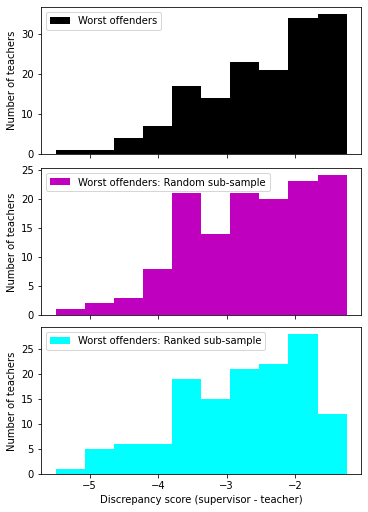

In [170]:
random_disc_score_wo = [random_disc_score[teacher_ids_selected.index(t_id)] for t_id in teacher_ids_wo]
ranked_disc_score_wo = [ranked_disc_score[teacher_ids_selected.index(t_id)] for t_id in teacher_ids_wo]

fig, ax = plt.subplots(nrows = 3, sharex = True, constrained_layout = True, figsize = (5, 7))

results = ax[0].hist(disc_score_wo, color = 'k', label = 'Worst offenders')
bins = results[1]
ax[1].hist(random_disc_score_wo, bins, color = 'm', label = 'Worst offenders: Random sub-sample', alpha = 1)
ax[2].hist(ranked_disc_score_wo, bins, color = 'cyan', label = 'Worst offenders: Ranked sub-sample', alpha = 1)
#plt.yscale('log')

for i in range(3):
    ax[i].legend()
    ax[i].set_ylabel('Number of teachers')
ax[2].set_xlabel('Discrepancy score (supervisor - teacher)')

To find how many worst offenders are in the bottom 10% using random sampling and ranked sampling, we will use bootstrapping. 
We will choose different random sets of 500 teachers (from the total pool of 892). For each random set, we will find the worst offenders based on real discrepancy score.
Then we will see how many of those worst offenders end up in the bottom 10% of discrepancy scores based on random and ranked samples. 

In [132]:
n_iter_bootstrap = 1000 # Number of times to perform bootstrapping
n_teachers_bootstrap = 20 # Number of teachers in each random set

perc_wo = 20 # Percentile of teachers to be selected as worst offenders
n_wo = int(perc_wo*n_teachers_bootstrap/100) # Number of teachers to be selected as worst offenders

random_perc_caught = []
ranked_perc_caught = []
cutoffs = []

print('Calculating for {0} bootstrap iterations'.format(n_iter_bootstrap))
for iter in tqdm(range(n_iter_bootstrap)):
    
    # Select teachers for bootstrap iteration
    teacher_ids_bootstrap = np.random.choice(teacher_ids_selected, size = n_teachers_bootstrap, replace = False)
    
    # Get worst offender disc score cutoff for bootstrap sample
    disc_score_bootstrap = [real_disc_score[teacher_ids_selected.index(t_id)] for t_id in teacher_ids_bootstrap]
    ordered_score_bootstrap = np.sort(disc_score_bootstrap) # Ascending order of discrepancy score for selected teachers - lower is worse
    cutoff = ordered_score_bootstrap[n_wo - 1]
    cutoffs.append(cutoff)
    
    # Get subset discrepancy scores for teachers in bootstrap 
    random_disc_score_bootstrap = [random_disc_score[teacher_ids_selected.index(t_id)] for t_id in teacher_ids_bootstrap]
    ranked_disc_score_bootstrap = [ranked_disc_score[teacher_ids_selected.index(t_id)] for t_id in teacher_ids_bootstrap]
    
    # Random subset: percentage of worst offenders in bottom 10%
    random_disc_score_wo = np.sort(random_disc_score_bootstrap)[:n_wo]
    perc_caught = np.sum([score <= cutoff for score in random_disc_score_wo])/n_wo*100
    random_perc_caught.append(perc_caught)
    
    # Ranked subset: percentage of worst offenders in bottom 10%
    ranked_disc_score_wo = np.sort(ranked_disc_score_bootstrap)[:n_wo]
    perc_caught = np.sum([score <= cutoff for score in ranked_disc_score_wo])/n_wo*100
    ranked_perc_caught.append(perc_caught)

Calculating for 1000 bootstrap iterations


100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 368.15it/s]


Text(0.5, 1.0, 'P value = 3.3547e-06')

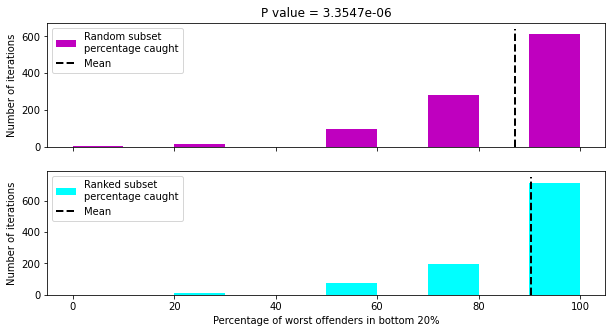

In [133]:
fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (10, 5))

ax[0].hist(random_perc_caught, color = 'm', label = 'Random subset\npercentage caught')
mean_accuracy = np.mean(random_perc_caught)
ylim = ax[0].get_ylim()
ax[0].plot([mean_accuracy, mean_accuracy], ylim, color = 'k', linewidth = 2, linestyle = '--', label = 'Mean')
ax[0].set_ylabel('Number of iterations')
ax[0].legend()

ax[1].hist(ranked_perc_caught, color = 'cyan', label = 'Ranked subset\npercentage caught')
mean_accuracy = np.mean(ranked_perc_caught)
ylim = ax[1].get_ylim()
ax[1].plot([mean_accuracy, mean_accuracy], ylim, color = 'k', linewidth = 2, linestyle = '--', label = 'Mean')
ax[1].set_ylabel('Number of iterations')
ax[1].set_xlabel('Percentage of worst offenders in bottom {0}%'.format(perc_wo))
ax[1].legend()

pval = mannwhitneyu(ranked_perc_caught, random_perc_caught, alternative = 'two-sided')[1]
ax[0].set_title('P value = {0}'.format(np.round(pval, 10)))

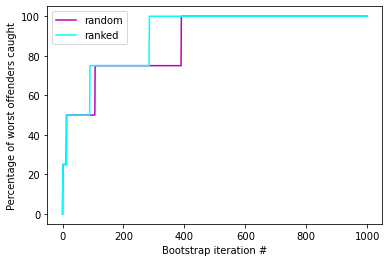

In [134]:
plt.figure()
plt.plot(np.sort(random_perc_caught), color = 'm', label = 'random')
plt.plot(np.sort(ranked_perc_caught), color = 'cyan', label = 'ranked')
plt.xlabel('Bootstrap iteration #')
plt.ylabel('Percentage of worst offenders caught')
plt.legend()